## Heat equation


The heat equation is a parabolic partial differential equation that describes the distribution of heat (or variation in temperature) in a given region over time. The general form of the equation in any coordinate system is given by:

\begin{align*}
\frac{\partial u}{\partial t} - \phi \nabla^2 u = f
\end{align*}

We will work here with the heat equation in one spatial dimension. This can be formulated as:

\begin{align*}
\mathcal{L}_{\bar{x}}^{\phi}u(\bar{x}) = \frac{\partial}{\partial t}u(\bar{x}) - \phi \frac{\partial^2}{\partial x^2}u(\bar{x}) = f(\bar{x}),
\end{align*}
where $\bar{x} = (t, x) \in \mathbb{R}^2$.


The fundamental solution to the heat equation gives us:

\begin{align*}
u(x,t) &= e^{-t}sin(2\pi x) \\
f(x,t) &= e^{-t}(4\pi^2 - 1)sin(2\pi x)
\end{align*}


#### Simulate data

In [1]:
import time
import numpy as np
import sympy as sp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
np.random.seed(int(time.time()))
def get_simulated_data(n):
    t = np.random.rand(n)
    x = np.random.rand(n)
    y_u = np.multiply(np.exp(-t), np.sin(2*np.pi*x))
    y_f = (4*np.pi**2 - 1) * np.multiply(np.exp(-t), np.sin(2*np.pi*x))
    return (t, x, y_u, y_f)

(t, x, y_u, y_f) = get_simulated_data(10)

#### Evaluate kernels

We use a reduced version of the kernel here.

1. $k_{uu}(x_i, x_j, t_i, t_j; \theta) =  e^ \left[ -\theta_1 (x_i-x_j)^2 - \theta_2 (t_i-t_j)^2 \right]$
2. $k_{ff}(\bar{x}_i,\bar{x}_j;\theta,\phi) = \mathcal{L}_{\bar{x}_i}^\phi \mathcal{L}_{\bar{x}_j}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) = \mathcal{L}_{\bar{x}_i}^\phi \left[ \frac{\partial}{\partial t_j}k_{uu} - \phi \frac{\partial^2}{\partial x_j^2} k_{uu} \right] \\
= \frac{\partial}{\partial t_i}\frac{\partial}{\partial t_j}k_{uu} - \phi \left[ \frac{\partial}{\partial t_i}\frac{\partial^2}{\partial x_j^2}k_{uu} + \frac{\partial^2}{\partial x_i^2}\frac{\partial}{\partial t_j}k_{uu} \right] + \phi^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$
3. $k_{fu}(\bar{x}_i,\bar{x}_j;\theta,\phi) = \mathcal{L}_{\bar{x}_i}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) 
= \frac{\partial}{\partial t_i}k_{uu} - \phi \frac{\partial^2}{\partial x_i^2}k_{uu}$

In [3]:
x_i, x_j, t_i, t_j, theta1, theta2, phi = sp.symbols('x_i x_j t_i t_j theta1 theta2 phi')

In [4]:
kuu_sym = sp.exp(-theta1*(x_i - x_j)**2 - theta2*(t_i - t_j)**2)
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2), kuu_sym, "numpy")
def kuu(t, x, theta1, theta2):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta1, theta2)
    return k

In [5]:
kff_sym = sp.diff(kuu_sym, t_j, t_i) \
        - phi*sp.diff(kuu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(kuu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(kuu_sym,x_j,x_j,x_i,x_i)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kff_sym, "numpy")
def kff(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

In [6]:
kfu_sym = sp.diff(kuu_sym,t_i) - phi*sp.diff(kuu_sym,x_i,x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kfu_sym, "numpy")
def kfu(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

In [7]:
def kuf(t, x, theta1, theta2, p):
    return kfu(t, x, theta1, theta2, p).T

#### create covariance matrix and NLML

```
params = [sig_u, l_u, phi]
```

In [8]:
def nlml(params, t, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(t, x, params[0], params[1]) + s*np.identity(x.size),
            kuf(t, x, params[0], params[1], params[2])
        ],
        [
            kfu(t, x, params[0], params[1], params[2]),
            kff(t, x, params[0], params[1], params[2]) + s*np.identity(x.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Optimize hyperparameters

In [9]:
nlml((1,1,0), t, x, y_u, y_f, 1e-6)

10.08849356029074

In [10]:
%%timeit
nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
minimize(
    nlml_wp,
    np.random.rand(3),
    method="Nelder-Mead",
    options={'maxiter' : 5000, 'fatol' : 0.001})

2.13 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def minimize_restarts(t, x, y_u, y_f, n = 10):
    nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
    all_results = []
    for it in range(0,n):
        all_results.append(
            minimize(
                nlml_wp,
                np.random.rand(3),
                method="Nelder-Mead",
                options={'maxiter' : 5000, 'fatol' : 0.001}))
    filtered_results = [m for m in all_results if 0 == m.status]
    return min(filtered_results, key = lambda x: x.fun)

In [12]:
m = minimize_restarts(t, x, y_u, y_f, 20)
m

 final_simplex: (array([[ 1.51464808, -1.4236345 , -0.03028208],
       [ 1.51462468, -1.42355069, -0.03028317],
       [ 1.51466738, -1.42367271, -0.03028443],
       [ 1.51467467, -1.42354775, -0.03028619]]), array([-3.63412215, -3.63412211, -3.63412211, -3.63412206]))
           fun: -3.6341221452010437
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 100
        status: 0
       success: True
             x: array([ 1.51464808, -1.4236345 , -0.03028208])

##### Estimated value of $\alpha$

In [13]:
np.exp(m.x[2])

0.9701718328188159

#### Analysis

##### Contour lines for the likelihood

In [14]:
delta = 0.01
theta1_range = np.arange(1, 2, delta)
theta2_range = np.arange(-2, 0, delta)
theta1_mesh, theta2_mesh = np.meshgrid(theta1_range, theta2_range)
nlml_mesh_fn = lambda mesh1, mesh2: nlml(np.array([mesh1, mesh2, 0]), t, x, y_u, y_f, 1e-7)
nlml_mesh = np.zeros(theta1_mesh.shape)
for i in range(nlml_mesh.shape[0]):
    for j in range(nlml_mesh.shape[1]):
        nlml_mesh[i][j] = nlml_mesh_fn(theta1_mesh[i][j], theta2_mesh[i][j])

In [15]:
contour_range = np.logspace(0, np.log(np.max(nlml_mesh) - np.min(nlml_mesh)), num=15, base=np.exp(1))
contour_range = np.min(nlml_mesh) + contour_range

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
f.suptitle("NLML contour lines")
cs1 = ax1.contour(theta1_mesh, theta2_mesh, nlml_mesh, contour_range)
plt.clabel(cs1, inline=1, fontsize=5)
ax1.set(xlabel= r"$ln(\theta_1)$", ylabel= r"$ln(\theta_2)$")
cs2 = ax2.contour(np.exp(theta1_mesh), np.exp(theta2_mesh), nlml_mesh, contour_range)
plt.clabel(cs1, inline=1, fontsize=5)
ax2.set(xlabel= r"$\theta_1$", ylabel= r"$\theta_2$")

[<matplotlib.text.Text at 0x10d094160>, <matplotlib.text.Text at 0x10d082a58>]

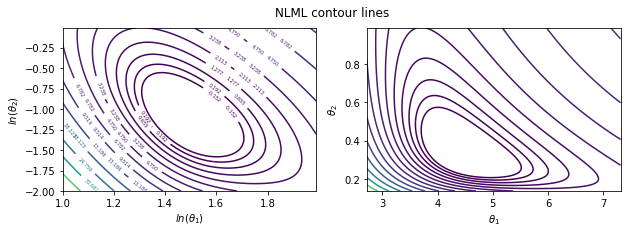

In [16]:
plt.show()

##### Profile likelihood

In [17]:
theta1_optim = np.zeros(theta1_range.size)
for i in range(theta1_range.size):
    nlml_opt_theta2 = lambda t2 : nlml(np.array([theta1_range[i], t2, 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta2)
    theta1_optim[i] = m['fun']

In [18]:
theta2_optim = np.zeros(theta2_range.size)
for i in range(theta2_range.size):
    def nlml_opt_theta1(t1):
        return nlml(np.array([t1, theta2_range[i], 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta1)
    theta2_optim[i] = m['fun']

In [19]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
f.suptitle("Profile likelihood")
ax1.plot(theta1_range, theta1_optim)
ax1.set(xlabel= r"$ln(\theta_1)$", ylabel= "nlml")
ax2.plot(theta2_range, theta2_optim, 'r')
ax2.set(xlabel= r"$ln(\theta_2)$", ylabel= "nlml")

[<matplotlib.text.Text at 0x10d45e518>, <matplotlib.text.Text at 0x10d454400>]

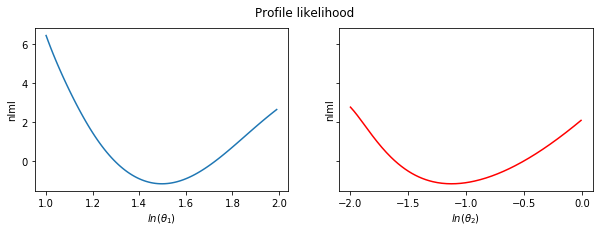

In [20]:
plt.show()

##### Errors


We generate 5 set of samples for each number of data points(n) in the range (5,25) as earlier. The absolute error in the parameter estimate and the computation times are plotted in the following figure.

In [21]:
n_range = np.arange(5, 25)
plot_data = np.zeros((5, n_range.size, 4))
for j in range(plot_data.shape[0]):
    print("iter ", j)
    for i in range(plot_data.shape[1]):
        print("# points: ", n_range[i])
        start_time = time.time()
        (t, x, y1, y2) = get_simulated_data(n_range[i])
        nlml_wp = lambda params: nlml(params, t, x, y1, y2, 1e-7)
        m = minimize(nlml_wp, np.random.rand(4), method="Nelder-Mead")
        end_time = time.time()
        plot_data[j,i,:] = np.array([m.nfev, m.nit, np.exp(m.x[2]), end_time - start_time])

iter  0
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  1
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  2
# points:  5
# points:  6


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  3
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  4
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24


In [134]:
from matplotlib.ticker import MaxNLocator

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

for i in range(1,4):
    ax1.plot(n_range[5:], abs(plot_data[i,5:,2] -1), "og")
ax1.set(xlabel = "Number of data points", ylabel = "Absolute error")
ax1.set_title("(A) Error in estimate of the parameter")
ax1.plot(n_range[5:], np.amin(abs(np.amin(plot_data, axis=2) - 1), axis=0)[5:])
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.axhline(0.01, color='black', linestyle='-.')
ax1.axhline(0.004, color='red', linestyle='-.')
ax1.axhline(0.002, color='black', linestyle='-.')

for i in range(1,4):
    ax2.plot(n_range[5:], plot_data[i,5:,3], "og")
ax2.set(xlabel = "Number of data points", ylabel = "Execution time")
ax2.set_title("(B) Execution time benchmark")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

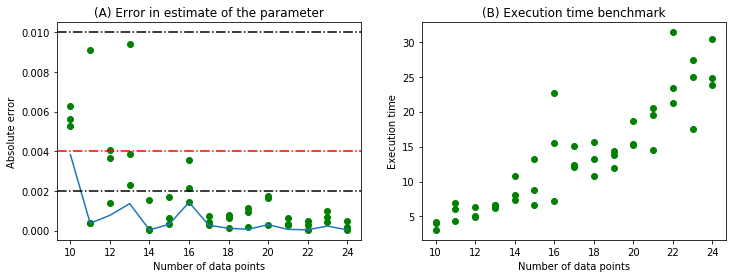

In [135]:
plt.show()

The minimum error for each value of n is bounded by 0.002 for n > 10. The computation time also increases monotonically with n.


##### With the full kernel

In [29]:
theta, l1, l2 = sp.symbols('theta l1 l2')

kuu_sym = theta*sp.exp(-(x_i - x_j)**2/(2*l1) - (t_i - t_j)**2/(2*l2))
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2), kuu_sym, "numpy")
def kuu(t, x, theta, l1, l2):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta, l1, l2)
    return k

kff_sym = sp.diff(kuu_sym, t_j, t_i) \
        - phi*sp.diff(kuu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(kuu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(kuu_sym,x_j,x_j,x_i,x_i)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2, phi), kff_sym, "numpy")
def kff(t, x, theta, l1, l2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta, l1, l2, p)
    return k

kfu_sym = sp.diff(kuu_sym,t_i) - phi*sp.diff(kuu_sym,x_i,x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2, phi), kfu_sym, "numpy")
def kfu(t, x, theta, l1, l2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta, l1, l2, p)
    return k

def kuf(t, x, theta, l1, l2, p):
    return kfu(t, x, theta, l1, l2, p).T

def nlml(params, t, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(t, x, params[0], params[1], params[2]) + s*np.identity(x.size),
            kuf(t, x, params[0], params[1], params[2], params[3])
        ],
        [
            kfu(t, x, params[0], params[1], params[2], params[3]),
            kff(t, x, params[0], params[1], params[2], params[3]) + s*np.identity(x.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

(t, x, y_u, y_f) = get_simulated_data(10)

In [30]:
nlml((1,1,1,0), t, x, y_u, y_f, 1e-6)

1100767.8910308597

In [31]:
%%timeit
nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
minimize(
    nlml_wp,
    np.random.rand(4),
    method="Nelder-Mead",
    options={'maxiter' : 5000, 'fatol' : 0.001})

6.93 s ± 1.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The reduced kernel takes less time for optimization as compared to the full one.

In [32]:
n_range = np.arange(5, 25)
plot_data_r = np.zeros((5, n_range.size, 4))
for j in range(plot_data_r.shape[0]):
    print("iter ", j)
    for i in range(plot_data_r.shape[1]):
        print("# points: ", n_range[i])
        start_time = time.time()
        (t, x, y1, y2) = get_simulated_data(n_range[i])
        nlml_wp = lambda params: nlml(params, t, x, y1, y2, 1e-7)
        m = minimize(nlml_wp, np.random.rand(4), method="Nelder-Mead")
        end_time = time.time()
        plot_data_r[j,i,:] = np.array([m.nfev, m.nit, np.exp(m.x[3]), end_time - start_time])

iter  0
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  1
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  2
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24
iter  3
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points

/usr/local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


iter  4
# points:  5
# points:  6
# points:  7
# points:  8
# points:  9
# points:  10
# points:  11
# points:  12
# points:  13
# points:  14
# points:  15
# points:  16
# points:  17
# points:  18
# points:  19
# points:  20
# points:  21
# points:  22
# points:  23
# points:  24


In [136]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

for i in range(plot_data.shape[0]):
    if(i != 3):
        ax1.plot(n_range[5:], abs(plot_data_r[i,5:,2] -1), "og")
ax1.set(xlabel = "Number of data points", ylabel = "Absolute error")
ax1.set_title("Error in estimate of the parameter")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.axhline(0.01, color='black', linestyle='-.')
ax1.axhline(0.004, color='red', linestyle='-.')
ax1.axhline(0.0025, color='black', linestyle='-.')

for i in range(plot_data.shape[0]):
    if(i != 3):
        ax2.plot(n_range[5:], plot_data_r[i,5:,3], "og")
ax2.set(xlabel = "Number of data points", ylabel = "Execution time")
ax2.set_title("Execution time benchmark")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

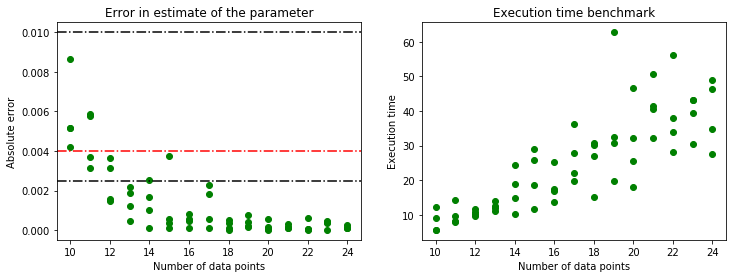

In [137]:
plt.show()

The same analysis as earlier in the chapter was done for the full kernel given by $\theta exp((\mathbf{x}-\mathbf{y})^T \Sigma (\mathbf{x}-\mathbf{y}))$ where $\Sigma = diag([l_1, l_2])$.


It can be noticed that the error in parameter estimate is slightly lower for the full kernel but the difference is not very significant. Meanwhile, the execution times are significantly different for both the cases. For 10 data points, the minimizer takes an average of 2.13 seconds for the reduced kernel while it is 6.93 seconds for the full kernel. This shows that not all hyperparameters might be necessary to get acceptable results. For some specific problems, having an intuition on the choice of kernels might be fruitful in the end.